# Task: The end goal is to develop a model to predict the drop off distance of deliveries. 

Drop off distance is the distance between actual location of a customer and the entered location by the customer. Ideally it will be 0.

In [58]:
import pickle
import geohash
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [2]:
with open('sample5.pkl', 'rb') as fp:
    df = pickle.load(fp)
orders = df.copy()
orders.head()

,order_id,customer_id,order_items_count,order_value,created_timestamp_local,delivery_geohash_precision8,delivery_postal_code,logistics_dropoff_distance,has_bell_instruction,has_call_instruction,has_gate_instruction,has_instruction,has_knock_instruction,has_leave_instruction,has_lift_instruction,has_lobby_instruction,has_phone_number
0,s4np-p5s4,t0tvs6rb,1.0,14.1,2021-03-14T21:34:37,w23b4rgp,752468,12.4738689461,False,False,False,True,False,False,False,False,False
1,w7rt-brik,i2huh7ar,1.0,10.5,2021-03-11T13:49:07,w21zbz0v,680677,24.4642677094,True,False,False,True,False,False,False,False,False
2,x9xn-lyb8,i8exg1qs,2.0,8.3,2021-03-17T11:18:06,w23b4qg5,757041,50.0267793822,False,False,False,True,False,False,False,False,False
3,s3pd-z4a1,sgu74iom,1.0,8.4,2021-03-04T18:31:32,w21z71mw,048943,45.2125286533,False,False,False,False,False,False,False,False,False
4,s8wi-1cmb,w0frb4ti,1.0,15.8,2021-03-31T15:52:45,w23b6346,753466,15.4258479763,False,False,False,True,False,False,False,False,False


In [3]:
columns = [
    'order_id',
    'customer_id',
    'order_items_count',
    'order_value',
    'created_timestamp_local',
    'delivery_geohash_precision8',
    'delivery_postal_code',
    'logistics_dropoff_distance',
    'has_bell_instruction',
    'has_call_instruction',
    'has_gate_instruction',
    'has_instruction',
    'has_knock_instruction',
    'has_leave_instruction',
    'has_lift_instruction',
    'has_lobby_instruction',
    'has_phone_number'
]

bool_cols = [
    'has_bell_instruction',
    'has_call_instruction',
    'has_gate_instruction',
    #'has_instruction',
    'has_knock_instruction',
    'has_leave_instruction',
    'has_lift_instruction',
    'has_lobby_instruction',
    'has_phone_number'
]
geo_spatial_cols = [
    'created_timestamp_local',
    'delivery_geohash_precision8',
    'delivery_postal_code'
]
order_numeric_cols = [    
    'order_items_count',
    'order_value'
]
target = ['logistics_dropoff_distance']

target_log = ['log_dropoff_distance']

# Data cleanup and validation

First, we need to assess the variables datatypes, as some of them might need type casting.

In [4]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129690 entries, 0 to 129689
Data columns (total 17 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   order_id                     129690 non-null  object 
 1   customer_id                  129690 non-null  object 
 2   order_items_count            129690 non-null  float64
 3   order_value                  129690 non-null  object 
 4   created_timestamp_local      129690 non-null  object 
 5   delivery_geohash_precision8  129690 non-null  object 
 6   delivery_postal_code         129690 non-null  object 
 7   logistics_dropoff_distance   129690 non-null  object 
 8   has_bell_instruction         129690 non-null  object 
 9   has_call_instruction         129690 non-null  object 
 10  has_gate_instruction         129690 non-null  object 
 11  has_instruction              129690 non-null  object 
 12  has_knock_instruction        129690 non-null  object 
 13 

In [5]:
orders = orders.convert_dtypes()

orders.order_value = orders.order_value.astype(float)

orders.logistics_dropoff_distance = round(orders.logistics_dropoff_distance.astype(float), 2)

orders.created_timestamp_local = pd.to_datetime(orders.created_timestamp_local)

orders[bool_cols] = orders[bool_cols].astype(int)

orders.dtypes

order_id                               string
customer_id                            string
order_items_count                       Int64
order_value                           float64
created_timestamp_local        datetime64[ns]
delivery_geohash_precision8            string
delivery_postal_code                   string
logistics_dropoff_distance            float64
has_bell_instruction                    int64
has_call_instruction                    int64
has_gate_instruction                    int64
has_instruction                       boolean
has_knock_instruction                   int64
has_leave_instruction                   int64
has_lift_instruction                    int64
has_lobby_instruction                   int64
has_phone_number                        int64
dtype: object

In [6]:
orders.describe()

,order_items_count,order_value,logistics_dropoff_distance,has_bell_instruction,has_call_instruction,has_gate_instruction,has_instruction,has_knock_instruction,has_leave_instruction,has_lift_instruction,has_lobby_instruction,has_phone_number
count,129690.000000,129690.000000,129690.000000,129690.000000,129690.000000,129690.000000,129690,129690.000000,129690.000000,129690.000000,129690.000000,129690.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,115417,NaN,NaN,NaN,NaN,NaN
mean,2.603585,21.028585,78.539877,0.047837,0.060560,0.039502,NaN,0.022253,0.045300,0.034937,0.029008,0.031961
std,1.976176,15.879431,1670.847969,0.213422,0.238522,0.194787,NaN,0.147506,0.207963,0.183621,0.167829,0.175896
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,11.500000,21.780000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,16.700000,38.005000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.000000,25.040000,63.510000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000


In [7]:
# There is no missing value
missing_val_percent = round(orders.isnull().mean().sort_values()*100, 2)
missing_val_percent

order_id                       0.0
has_lift_instruction           0.0
has_leave_instruction          0.0
has_knock_instruction          0.0
has_instruction                0.0
has_gate_instruction           0.0
has_call_instruction           0.0
has_lobby_instruction          0.0
has_bell_instruction           0.0
delivery_postal_code           0.0
delivery_geohash_precision8    0.0
created_timestamp_local        0.0
order_value                    0.0
order_items_count              0.0
customer_id                    0.0
logistics_dropoff_distance     0.0
has_phone_number               0.0
dtype: float64

# Overview of the Data Distributions

In [8]:
# User analysis: most of the customers have 1 order
orders.groupby('customer_id').agg('count')['order_id'].value_counts()

1     83306
2     14831
3      3577
4       887
5       283
6        98
7        41
8        12
9         5
12        1
Name: order_id, dtype: int64

In [9]:
# Sanity check
orders.groupby(['order_id']).agg('count').value_counts()
#orders['has_phone_number'].value_counts()

customer_id  order_items_count  order_value  created_timestamp_local  delivery_geohash_precision8  delivery_postal_code  logistics_dropoff_distance  has_bell_instruction  has_call_instruction  has_gate_instruction  has_instruction  has_knock_instruction  has_leave_instruction  has_lift_instruction  has_lobby_instruction  has_phone_number
1            1                  1            1                        1                            1                     1                           1                     1                     1                     1                1                      1                      1                     1                      1                   129690
dtype: int64

In [10]:
#orders.hist(bins=20, figsize=(15,20), xrot=30)
#plt.show()

In [11]:
# When 'has_X_instruction' columns equal to 1 in a row then the 'has_instruction' column is also 1
# I remove the has_instruction column, as it can be 1 even when the 'has_X_instruction' is 0
# Or is there another category of instruction which is not in this data?
orders[
       (orders.has_bell_instruction == 1) |
       (orders.has_gate_instruction == 1) |
       (orders.has_call_instruction == 1) |
       (orders.has_knock_instruction == 1) |
       (orders.has_leave_instruction == 1) |
       (orders.has_lift_instruction == 1) |
       (orders.has_lobby_instruction == 1) |
       (orders.has_phone_number == 1)
]['has_instruction'].value_counts()


True    28204
Name: has_instruction, dtype: Int64

# Feature exploration and feature engineering

## Analysing target variable

The Drop Off distance is power-law-like distributed.

/home/dd/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


,logistics_dropoff_distance
count,129690.000000
mean,78.539877
std,1670.847969
min,0.000000
25%,21.780000
50%,38.005000
75%,63.510000
max,588302.580000


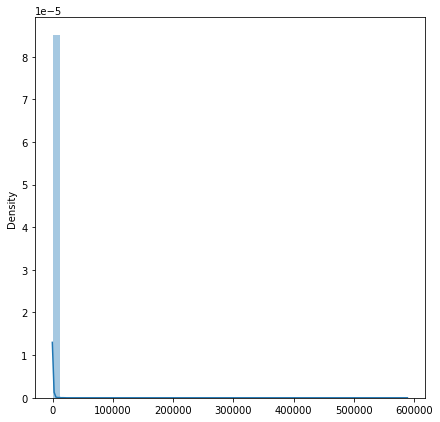

In [12]:
fig, ax = plt.subplots(figsize=(7, 7))
sns.distplot(orders[target], ax=ax)

orders[target].describe()

/home/dd/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='log_dropoff_distance', ylabel='Density'>

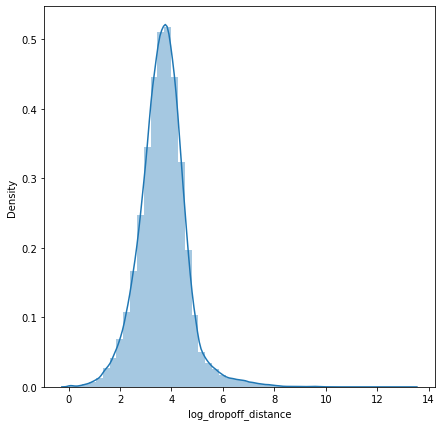

In [13]:
orders['log_dropoff_distance'] = orders['logistics_dropoff_distance'].apply(lambda x: np.log1p(x))

fig, ax = plt.subplots(figsize=(7, 7))
sns.distplot(orders['log_dropoff_distance'], ax=ax)

In [14]:
orders[['order_items_count', 'order_value', 'log_dropoff_distance']].corr()['log_dropoff_distance'].sort_values()

order_items_count      -0.001090
order_value             0.017393
log_dropoff_distance    1.000000
Name: log_dropoff_distance, dtype: float64

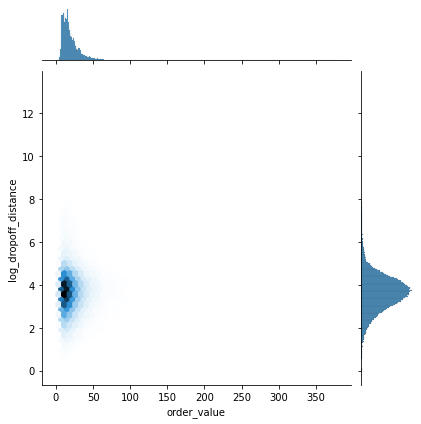

In [26]:
# I would have made a more detailed plot if I had more time
sns.jointplot(data=orders, x='order_value', y='log_dropoff_distance', kind='hex')

## Analysing temporal and geographical data

In [15]:
geo_spatial_cols = [
    'created_timestamp_local',
    'delivery_geohash_precision8',
    'delivery_postal_code'
]

def lat_long(x):
    res = geohash.decode(x)
    return res[0], res[1]

dic = orders['delivery_geohash_precision8'].value_counts()

temp = orders['delivery_geohash_precision8'].map(lat_long)
orders['lat'] = temp.apply(lambda x: x[0])
orders['long'] = temp.apply(lambda x: x[1])

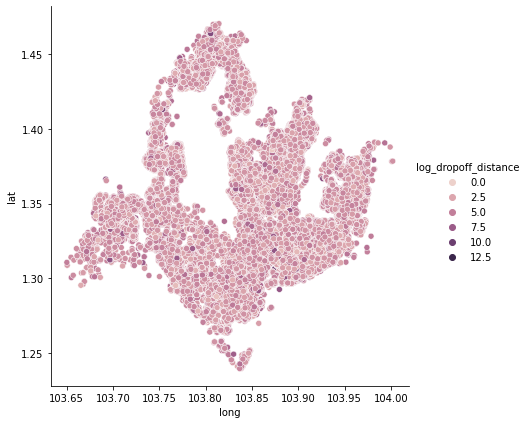

In [16]:
sns.relplot(x="long", y="lat", hue='log_dropoff_distance', data=orders, height=6)

In [17]:
# convert geohash to (latitude, longitude). Show them on the map. Cluster the data based on (lat, long). check if these clusters could be a good feature, like some areas have more 
cluster_num = [5, 10, 20, 25, 30]

for n in cluster_num:
    kmeans = KMeans(n_clusters=n)
    col_name = 'cluster_%s' %n
    orders[col_name] = kmeans.fit_predict(orders[['lat', 'long']])
    orders[col_name] = orders[col_name].astype('category')

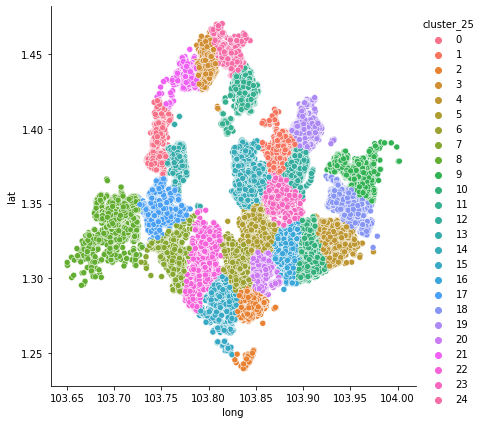

In [18]:
sns.relplot(x='long', y='lat', hue='cluster_25', data=orders, height=6)

Here I analysed the time data. I created features from the columns, like day of week,and check if there is meaningful differences in dropp off distance. I chose median for aggragation, since our target variable is skewed. I didn't find meaningful differences.

In [19]:
orders.groupby('cluster_10').agg('mean')[target_log]

,log_dropoff_distance
cluster_10,
0,3.657565
1,3.545172
2,3.662215
3,3.721363
4,3.675233
5,3.665789
6,3.614146
7,3.684290
8,3.745309


            log_dropoff_distance
lunch_hour                      
0                       3.663818
1                       3.662792


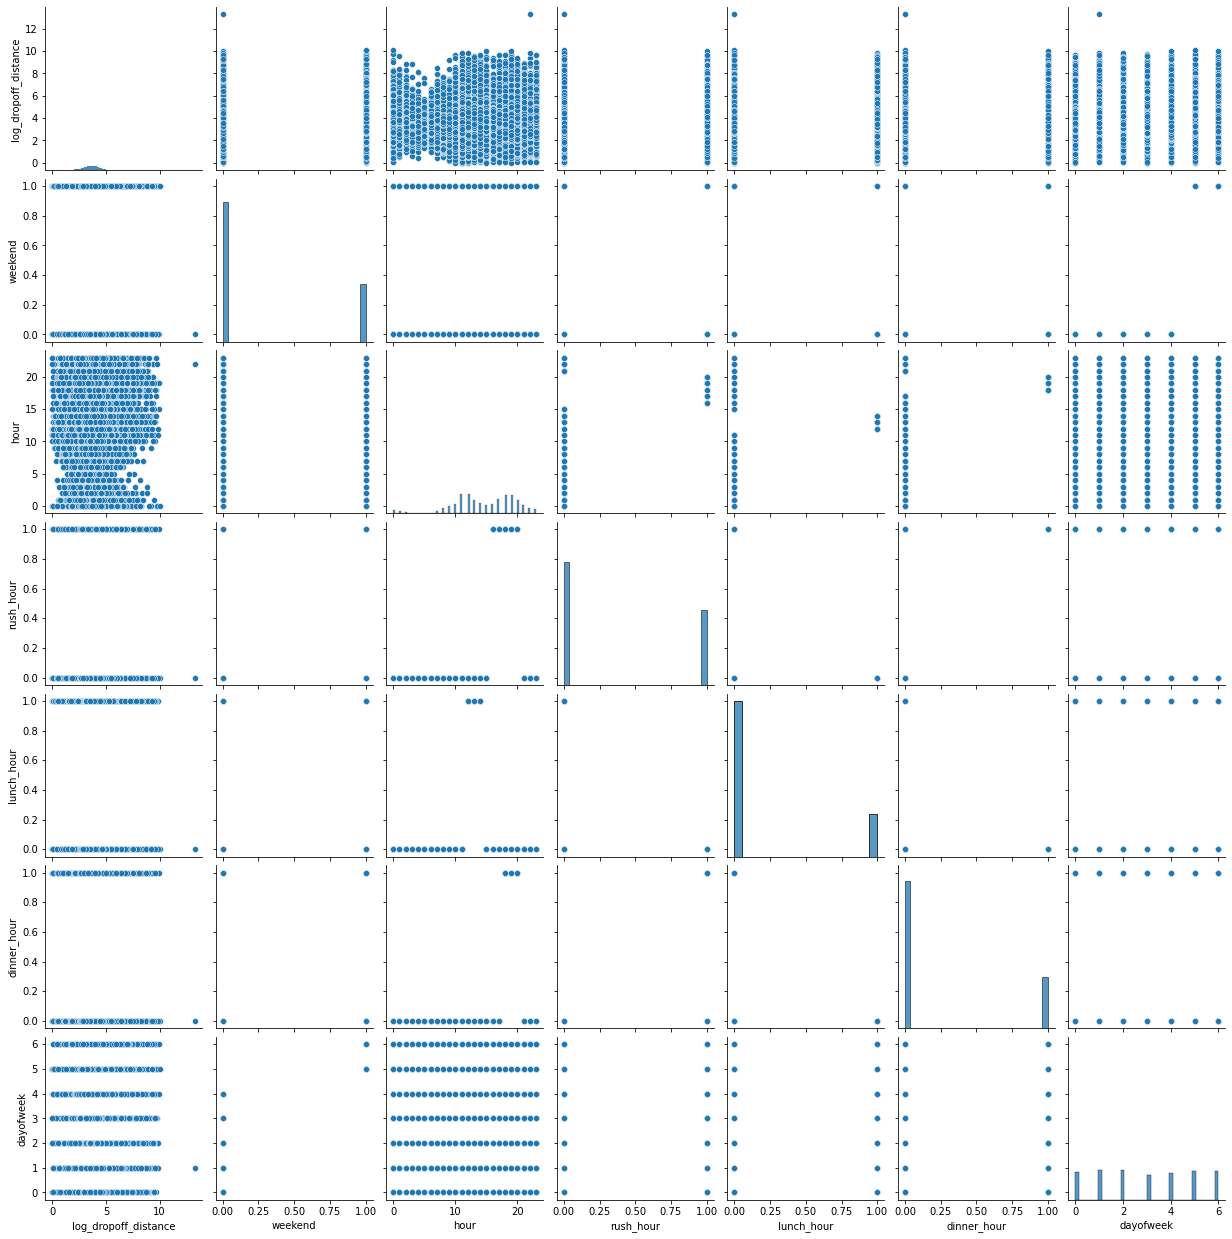

In [20]:
time = orders['created_timestamp_local']

orders.loc[:, 'weekend'] = (time.dt.weekday >=5).astype(int)
orders.loc[:, 'hour'] = time.dt.hour
orders.loc[:, 'rush_hour'] = ((time.dt.hour >= 16 ) & (time.dt.hour <= 20 )).astype(int)
orders.loc[:, 'lunch_hour'] = ((time.dt.hour >= 12 ) & (time.dt.hour <= 14 )).astype(int)
orders.loc[:, 'dinner_hour'] = ((time.dt.hour >= 18 ) & (time.dt.hour <= 20 )).astype(int)
orders.loc[:, 'dayofweek'] = time.dt.dayofweek

#orders.groupby('weekend').agg('median')[target_log]
print(orders.groupby('lunch_hour').agg('median')[target_log])
#orders.groupby('hour').agg('median')[target_log]
#orders.groupby('rush_hour').agg('median')[target_log]
#orders.groupby('dayofweek').agg('median')[target_log]

sns.pairplot(orders[['log_dropoff_distance', 'created_timestamp_local', 'weekend', 'hour', 'rush_hour', 'lunch_hour', 'dinner_hour', 'dayofweek']])

## Analysing instruction columns

We don't see much difference plotting instruction vs. drop off distance.

In [ ]:
fig, axs = plt.subplots(ncols=4, nrows=2)
plt.gcf().set_size_inches(16, 10)
sns.stripplot(data=orders, y = 'has_gate_instruction', x='log_dropoff_distance', ax=axs[0][0])
sns.stripplot(data=orders, x = 'has_bell_instruction', y='log_dropoff_distance', ax=axs[0][1])#
sns.stripplot(data=orders, x = 'has_lobby_instruction', y='log_dropoff_distance', ax=axs[0][2])
sns.stripplot(data=orders, x = 'has_call_instruction', y='log_dropoff_distance', ax=axs[0][3])
sns.stripplot(data=orders, x = 'has_lift_instruction', y='log_dropoff_distance', ax=axs[1][0])
sns.stripplot(data=orders, x = 'has_phone_number', y='log_dropoff_distance', ax=axs[1][1])
sns.stripplot(data=orders, x = 'has_knock_instruction', y='log_dropoff_distance', ax=axs[1][2])
sns.stripplot(data=orders, x = 'has_leave_instruction', y='log_dropoff_distance', ax=axs[1][3])

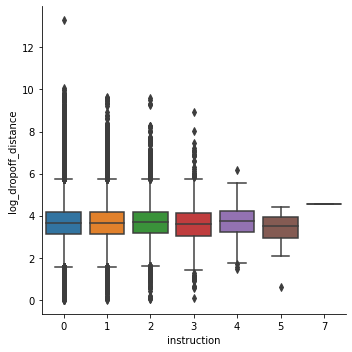

In [21]:
orders['instruction'] = orders.loc[:,bool_cols].sum(axis=1)
sns.catplot(data=orders, x = 'instruction', y='log_dropoff_distance', kind="box")

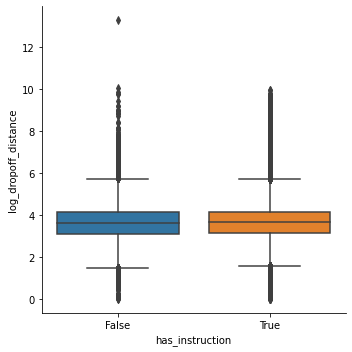

In [22]:
sns.catplot(data=orders, x = 'has_instruction', y='log_dropoff_distance', kind="box")

In [25]:
orders.drop(['order_id', 'customer_id', 'created_timestamp_local'], axis=1, inplace=True)

orders['postal_code_median_target_encoding'] = orders.groupby("delivery_postal_code")[target].transform("median")
orders.drop('delivery_postal_code', axis=1, inplace=True)

orders['delivery_geohash_precision8_median_target_encoding'] = orders.groupby('delivery_geohash_precision8')[target].transform("median")
orders.drop('delivery_geohash_precision8', axis=1, inplace=True)

orders

,order_items_count,order_value,logistics_dropoff_distance,has_bell_instruction,has_call_instruction,has_gate_instruction,has_instruction,has_knock_instruction,has_leave_instruction,has_lift_instruction,...,cluster_30,weekend,hour,rush_hour,lunch_hour,dinner_hour,dayofweek,instruction,postal_code_median_target_encoding,delivery_geohash_precision8_median_target_encoding
0,1,14.10,12.47,0,0,0,True,0,0,0,...,15,1,21,0,0,0,6,0,47.070,47.070
1,1,10.50,24.46,1,0,0,True,0,0,0,...,21,0,13,0,1,0,3,1,26.510,33.420
2,2,8.30,50.03,0,0,0,True,0,0,0,...,15,0,11,0,0,0,2,0,47.500,43.350
3,1,8.40,45.21,0,0,0,False,0,0,0,...,2,0,18,1,0,1,3,0,57.835,57.835
4,1,15.80,15.43,0,0,0,True,0,0,0,...,15,0,15,0,0,0,2,0,34.700,25.850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129685,3,44.40,26.71,0,0,0,True,0,0,0,...,27,0,19,1,0,1,4,0,38.585,38.585
129686,3,18.90,33.01,0,0,0,True,0,0,0,...,6,0,10,0,0,0,0,0,35.765,24.780
129687,4,20.75,23.18,0,0,0,True,0,0,0,...,14,1,15,0,0,0,6,0,39.230,33.890
129688,5,18.80,16.24,0,0,0,True,0,0,0,...,25,1,21,0,0,0,6,0,38.040,38.040


## Finding important features and training different models

I used random forest to find the important feature and later predict the outcome:

In [27]:
col_names = orders.columns.drop(['logistics_dropoff_distance', 
                                  'log_dropoff_distance',
                                  'lat', 
                                  'long', 
                                  'delivery_geohash_precision8_median_target_encoding', 
                                  'postal_code_median_target_encoding'])

X = orders[col_names]
y = orders[target_log]

# initialize the model
model = RandomForestRegressor()
# fit the model
model.fit(X, y)

/tmp/ipykernel_62095/326514375.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X, y)


RandomForestRegressor()

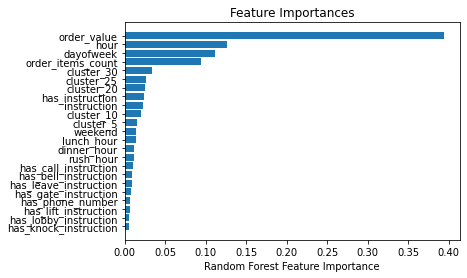

In [28]:
importances = model.feature_importances_
idxs = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(idxs)), importances[idxs], align='center')
plt.yticks(range(len(idxs)), [col_names[i] for i in idxs])
plt.xlabel('Random Forest Feature Importance')
plt.show()

In [61]:
def training_testing_pipeline(regressor):
    
    # TODO: add and test other hyperparameters  e.g. max_depth, criterion etc.
    param_grid = {
    'n_estimators': [100, 200, 250]
    }

    model = model_selection.GridSearchCV(
        estimator=regressor,
        param_grid=param_grid,
        scoring='neg_root_mean_squared_error',
        n_jobs=1,
        cv=5
    )

    model.fit(X_train, y_train)

    print(f'Best score: {-1 * model.best_score_}')

    print('Best parameters set:')
    best_model = model.best_estimator_
    best_parameters = best_model.get_params()

    for param_name in sorted(param_grid.keys()):
        print(f'\t{param_name}: {best_parameters[param_name]}')

    best_model.fit(X_train, y_train)

    preds = best_model.predict(X_test)
    rsme = np.sqrt(metrics.mean_squared_error(y_test, preds))
    print(f'Score on the Test set: {rsme}')
    
    plot_important_features(best_model, X_train.columns)

    
def plot_important_features(model, cols):
    
    importances = model.feature_importances_
    idxs = np.argsort(importances)
    
    plt.title('Feature Importances')
    plt.barh(range(len(idxs)), importances[idxs], align='center')
    plt.yticks(range(len(idxs)), [cols[i] for i in idxs])
    plt.xlabel('Random Forest Feature Importance')
    plt.show()

In [63]:
cols = ['order_value', 'hour', 'dayofweek', 'order_items_count', 'cluster_30']

X = orders[cols]
y = orders[target_log]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.33, random_state=42)

Best score: 0.9713602179895808
Best parameters set:
	n_estimators: 250
Score on the Test set: 0.9790576731462388


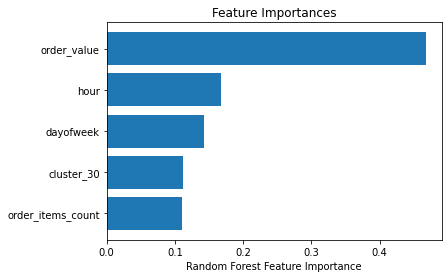

In [65]:
regressor1 = RandomForestRegressor()
training_testing_pipeline(regressor1)

I also used Gradient Boosting regression: 

Best score: 0.9193629812076856
Best parameters set:
	n_estimators: 100
Score on the Test set: 0.9236560846330952


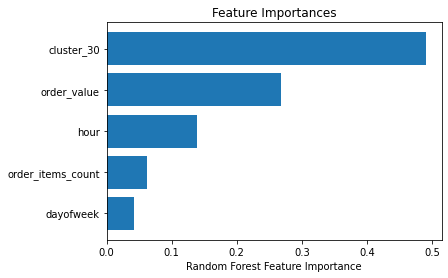

In [62]:
regressor2 = GradientBoostingRegressor()
training_testing_pipeline(regressor2)

# Ideas 

With more time, I would have done the followings: 
  1. Integrating different data sources could give more insights:
    - User information such as age
    - Weather data such as rain, snow amount
    - Poverty data of each region
  2. Testing more hypothesis and plotting them
  3. Testing the relationship between number of clusters and the target value
  4. PCA on has_X_instruction columns for dimensionality reduction
  5. Adding and testing other hyperparameters of the models e.g. max_depth, criterion etc.
  6. Adding more comments to the code!
  7. Using spark for reading the json file and analysing the data
  8. The gradient boosting regressor has lower rsme error compared to the random forest regressor. I would have tested a linear regression model for the baseline.